### 1. Load data

In [1]:
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=6)
 
unstained <- FALSE # TRUE if samples were not stained, TRUE if samples have been stained

if(unstained){
    summary <- read_csv("./unstained/summary.csv")
}else{
    stained_summary <- read_csv("./stained/summary.csv") # load summary data
    unstained_summary <- read_csv("./unstained/summary.csv")}

meta <- read_csv("metadata_copy.txt",col_types = cols(date = col_character())) 

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.1     v purrr   0.3.4
v tibble  3.0.1     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Parsed with column specification:
cols(
  population = col_character(),
  count = col_double(),
  scatter = col_double(),
  red = col_double(),
  orange = col_double(),
  file = col_character()
)

Parsed with column specification:
cols(
  population = col_character(),
  count = col_double(),
  scatter = col_double(),
  red = col_double(),
  orange = col_double(),
  file = col_character()
)



### 2. Convert metadata

In [2]:
meta[1:3,] # print the first few lines to know how to parse metadata

date,date ran,old file,file,station,cast,lat,lon,depth,experiment,treatment,replicate,run time,event rate,flow rate,volume,.SCO file,stain,flag,comments
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
2017-05-29T15:39:29,18/12/17,S2C2 A 15m,station_001,2,2,25.76833,-158.0133,15,NA,T0,A,5,165,33,167.0,Gradient_Edge,0,0,Pro big and bright but no syn. Kind of strange. Maybe they weren't into the gyre yet?
2017-05-29T15:39:29,19/12/17,S2C2 A 15m stained,sybr_001,2,2,25.76833,-158.0133,15,NA,T0,A,5,220,33,167.7,Gradients_Edge-BACT,1,0,very little syn in unstained sample
2017-05-29T15:39:29,29/01/18,S2C2 A 25m,station_002,2,2,25.76833,-158.0133,25,NA,NA,A,5,160,33.5,171.6,Gradient_Edge,0,0,NA


In [3]:
# add required columns (filename, volume and comments) from metadata
file <- paste0(meta$file,".fcs") # format  sample name to filename (.fcs)
time <- meta$date
lat <- meta$lat
lon <- meta$lon
depth <- meta$depth
replicate <- meta$replicate
volume <- meta$volume
stain <- meta$stain
flag <- meta$flag
comments <- meta$comments

# add required metadata for CMAP
# time <- as.POSIXct(meta$date, format="%d/%b/%y", tz="UTC") 
# lat <- NA
# lon <- NA

# add key information from sample label
# label <- matrix(unlist(list(strsplit(meta$label, split=" "))), ncol=3, byrow=T) 
# treatment <- label[,1]
# timepoint <- label[,2]
# replicate <- label[,3]

# create new metadata
metadata <- tibble(file, time, lat, lon, depth, replicate, volume, stain, flag, comments)

### 3. Merge files
#### a. Merge unstained and unstained summary data

In [4]:
if(unstained == FALSE){
  summary <- merge(unstained_summary, stained_summary, all=TRUE)
  summary[1:3,]
}

,population,count,scatter,red,orange,file
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,bacteria,26495,0.001319,0.035168,0.013238,sybr_206.fcs
2,bacteria,26513,0.001906,0.044358,0.020581,sybr_171.fcs
3,bacteria,31654,0.001525,0.036853,0.015170,sybr_125.fcs


#### b. Add metadata to summary data

In [5]:
all <- merge(summary, metadata, by="file")
all[1:3,]
all$abundance <- all$count / all$volume

,file,population,count,scatter,red,orange,time,lat,lon,depth,replicate,volume,stain,flag,comments
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,station_001.fcs,unknown,34264,0.003030,0.002462,0.001248,2017-05-29T15:39:29,25.76833,-158.0133,15,A,167,0,0,Pro big and bright but no syn. Kind of strange. Maybe they weren't into the gyre yet?
2,station_001.fcs,beads,2926,1.000000,1.000000,1.000000,2017-05-29T15:39:29,25.76833,-158.0133,15,A,167,0,0,Pro big and bright but no syn. Kind of strange. Maybe they weren't into the gyre yet?
3,station_001.fcs,synecho,7,0.235974,4.466459,1.282786,2017-05-29T15:39:29,25.76833,-158.0133,15,A,167,0,0,Pro big and bright but no syn. Kind of strange. Maybe they weren't into the gyre yet?


### 4. Calculate abundance
#### a. Check abundance

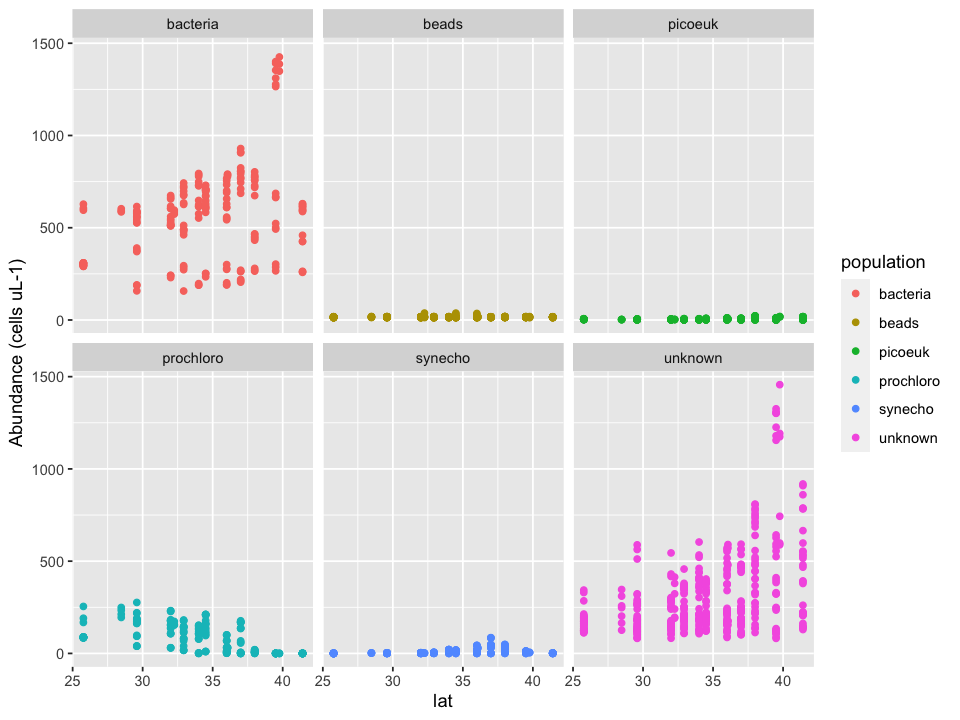

In [6]:
all %>%
  ggplot(aes(lat, abundance, col=population)) + 
  geom_point() + 
  facet_wrap(~ population) +
  ylab("Abundance (cells uL-1)")

#### b. Calculate bacteria abundance

In [7]:
pro <- subset(all, population == "prochloro")
bact <- subset(all, population == "bacteria")

new.all <- all
for (i in 1:nrow(pro)){
  file_number <- regmatches(pro$file[i], regexpr(pattern = "[0-9].*fcs" , text = pro$file[i]))  # removes prefix from the current file so the stained and unstained files will be identical
  matching_file_id <- grep(file_number, bact$file) # find the file in stained samples that matches the file number
  id <- which(all$file == bact$file[matching_file_id] & all$population == "bacteria") # return the index of the file that matches the Pro file numbner
  if(length(id) !=0) new.all$abundance[id] <- all$abundance[id] - pro$abundance[i] # et voila!
}

#### c. Check new abundance

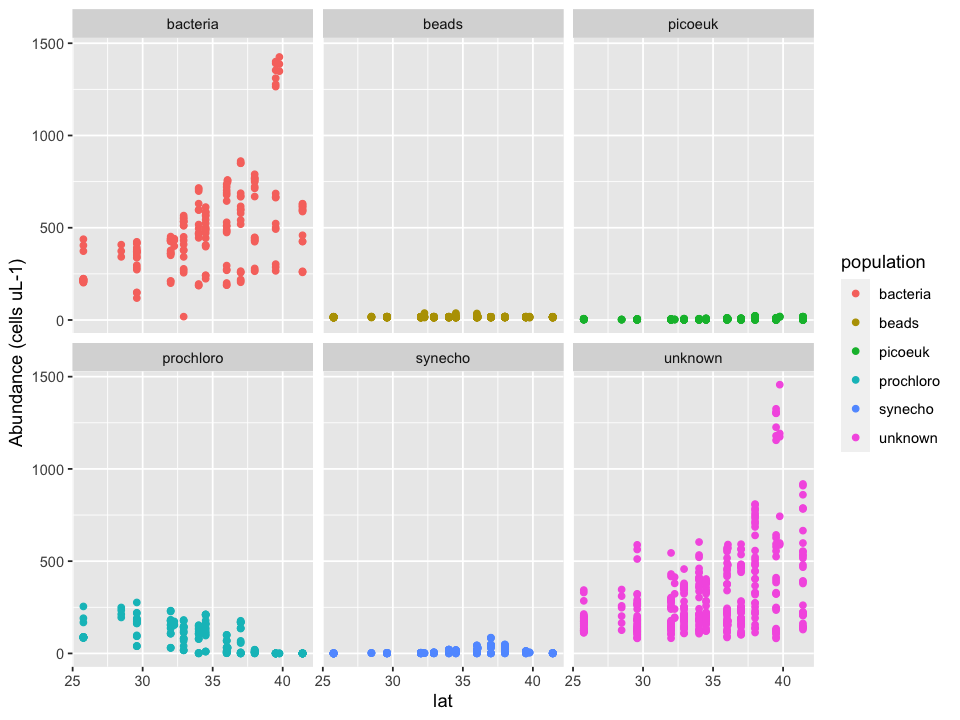

In [8]:
new.all %>%
  ggplot(aes(lat, abundance, col=population)) + 
  geom_point() + 
  facet_wrap(~ population) +
  ylab("Abundance (cells uL-1)")

### 5. Plotting
#### a. Abundance

`summarise()` regrouping output by 'lat', 'abundance' (override with `.groups` argument)

Warning message:
"Removed 202 rows containing missing values (geom_segment)."
Warning message:
"Removed 215 rows containing missing values (geom_segment)."
Warning message:
"Removed 214 rows containing missing values (geom_segment)."
Warning message:
"Removed 215 rows containing missing values (geom_segment)."


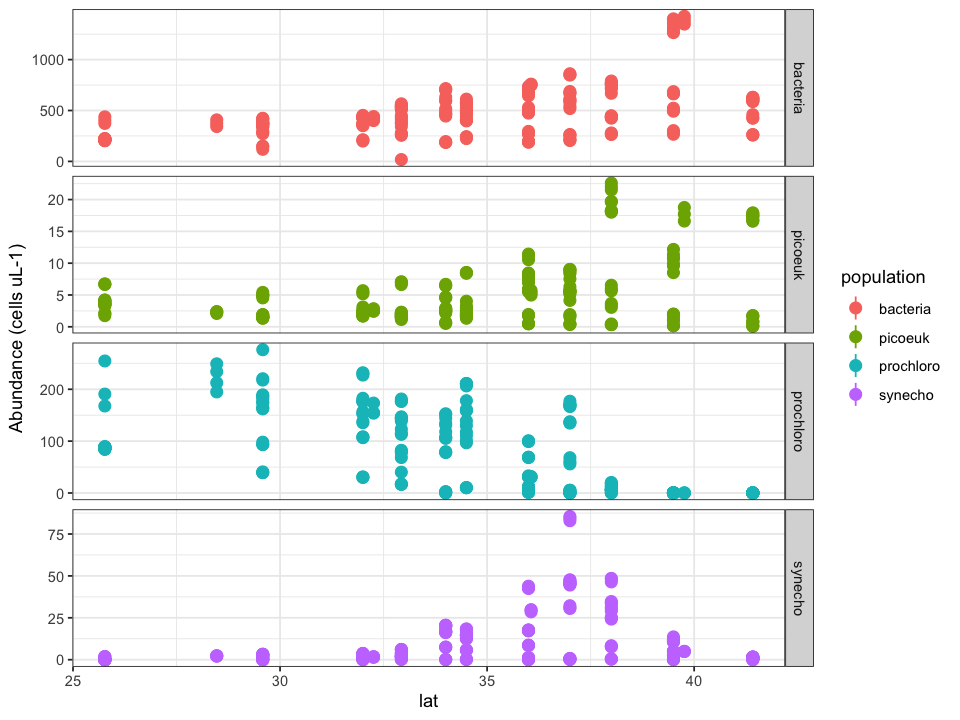

In [9]:
new.all %>%
    dplyr::filter(population != "unknown" & population != "beads") %>%
    dplyr::group_by(lat, abundance, population) %>%
    dplyr::summarize(sd = sd(abundance),
              avg=mean(abundance)) %>%
    ggplot(aes(lat, avg, col=population)) +
    geom_point(size=3) +
    geom_linerange(aes(ymin=avg-sd, ymax=avg+sd)) +
    facet_grid(population ~ ., scale="free_y") + 
    theme_bw() +
    ylab("Abundance (cells uL-1)")

#### b. Scatter

`summarise()` regrouping output by 'lat', 'abundance' (override with `.groups` argument)

Warning message:
"Removed 202 rows containing missing values (geom_segment)."
Warning message:
"Removed 215 rows containing missing values (geom_segment)."
Warning message:
"Removed 214 rows containing missing values (geom_segment)."
Warning message:
"Removed 215 rows containing missing values (geom_segment)."


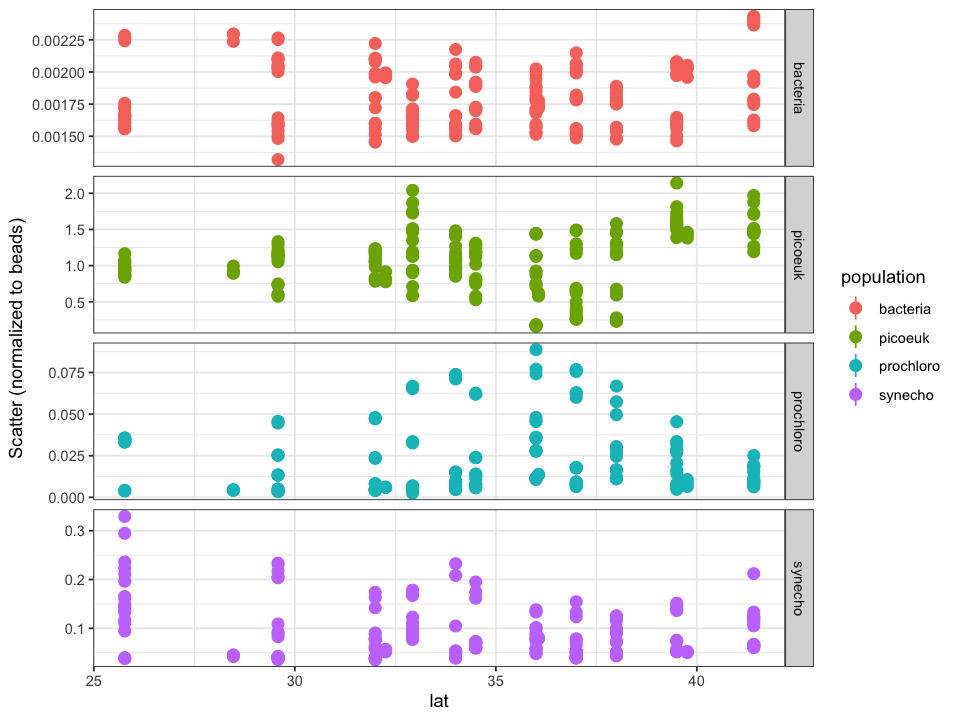

In [10]:
new.all %>%
    dplyr::filter(population != "unknown" & population != "beads") %>%
    dplyr::group_by(lat, abundance, population) %>%
    dplyr::summarize(sd = sd(scatter),
              avg=mean(scatter)) %>%
    ggplot(aes(lat, avg, col=population)) +
    geom_linerange(aes(ymin=avg-sd, ymax=avg+sd)) +
    geom_point(size=3) +
    facet_grid(population ~ ., scale="free_y") + 
    theme_bw() +
    ylab("Scatter (normalized to beads)")

#### c. Red fluorescence

`summarise()` regrouping output by 'lat', 'population' (override with `.groups` argument)

Warning message:
"Removed 202 rows containing missing values (geom_segment)."
Warning message:
"Removed 215 rows containing missing values (geom_segment)."
Warning message:
"Removed 214 rows containing missing values (geom_segment)."
Warning message:
"Removed 215 rows containing missing values (geom_segment)."


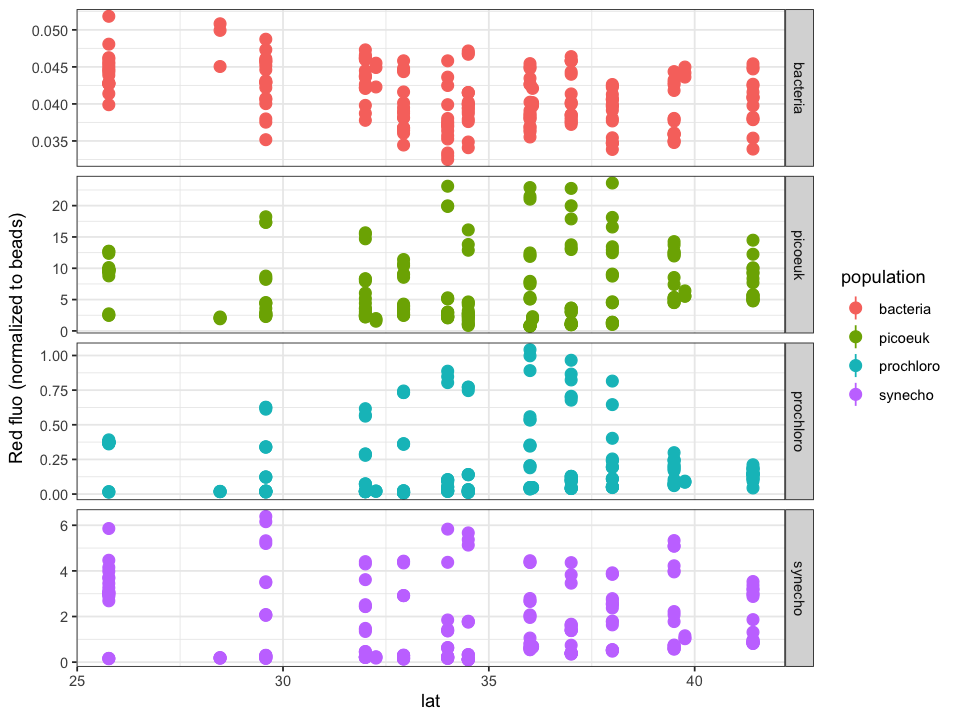

In [11]:
new.all %>%
    dplyr::filter(population != "unknown" & population != "beads") %>%
    dplyr::group_by(lat, population, abundance) %>%
    dplyr::summarize(sd = sd(red),
              avg=mean(red)) %>%
    ggplot(aes(lat, avg, col=population)) +
    geom_linerange(aes(ymin=avg-sd, ymax=avg+sd)) +
    geom_point(size=3) +
    facet_grid(population ~ ., scale="free_y") + 
    theme_bw() +
    ylab("Red fluo (normalized to beads)")

### 6. Save data

In [14]:
library(FCSplankton)
library(openxlsx)

project <- basename(getwd())
cruise <- "MGL1704" # Cruise ID (ex. KM1906); leave blank if samples were not collected during a cruise
cruise_nickname <- "Gradients 2" # cruise/project nickname (ex. Gradients 2) ; leave blank if samples were not collected during a cruise

xls_convert(data=new.all, cruise, project, version = "v1.0") ## keep getting error opening xlsx file
